# Clustering with Derived Variables

First let's load the data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('Filter_Unmerged.csv').drop(columns = ['Unnamed: 0'])
df.head()

,FULL NAME,TEAM,POS,AGE,GP,MPG,MIN%,USG%,Tor%,FTA,...,3PM,FGM,FGA,PTS,MINS,AST,REB,BLK,TOV,STL
0,Alex Abrines,Okc,G,25.69,31,19.0,39.5,12.2,7.9,13,...,41.021,56.021,157,164.3,589.0,18.6,46.5,5.89,13.95,17.05
1,Jaylen Adams,Atl,G,22.93,34,12.6,26.2,13.5,19.7,9,...,25.012,38.008,110,108.8,428.4,64.6,61.2,5.10,27.88,12.92
2,Steven Adams,Okc,C,25.73,80,33.4,69.5,16.4,12.8,292,...,0.000,480.972,809,1112.0,2672.0,128.0,760.0,76.80,138.40,119.20
3,Bam Adebayo,Mia,C,21.73,82,23.3,48.6,15.8,17.1,226,...,3.000,279.948,486,729.8,1910.6,180.4,598.6,64.78,121.36,72.16
4,Deng Adel,Cle,F,22.19,19,10.2,21.3,9.9,13.7,4,...,6.003,11.008,36,32.3,193.8,5.7,19.0,3.99,6.08,0.95


### Feature Engineering

Let's create some new columns that will be more usful in calssifying players acccording to their styles.

In [2]:
for col in ['PTS', 'AST', 'REB', 'BLK', 'TOV', 'STL']:
    df[col + 'P36'] = df[col] * 36 / df['MINS']
df['O/DRTG'] = df['ORTG'] / df['DRTG']
df['3/2FGA'] = df['3PA'] / df['2PA']
df['%FTA'] = df['FTA'] / (df['FGA'] + df['FTA'])
print(list(df.columns))

['FULL NAME', 'TEAM', 'POS', 'AGE', 'GP', 'MPG', 'MIN%', 'USG%', 'Tor%', 'FTA', 'FT%', '2PA', '2P%', '3PA', '3P%', 'eFG%', 'TS%', 'PPG', 'RPG', 'TRB%', 'APG', 'AST%', 'SPG', 'BPG', 'TOPG', 'VI', 'ORTG', 'DRTG', '2PM', '3PM', 'FGM', 'FGA', 'PTS', 'MINS', 'AST', 'REB', 'BLK', 'TOV', 'STL', 'PTSP36', 'ASTP36', 'REBP36', 'BLKP36', 'TOVP36', 'STLP36', 'O/DRTG', '3/2FGA', '%FTA']


Gary Clark is an outlier because of his disproportionate ratio of 3FGA to 2FGA, so we remove him.

In [3]:
print(df.shape[0])
df = df[df['FULL NAME'] != 'Gary Clark']
print(df.shape[0])

440
439


### Feature Selection

Here, we create a list of the columns we want to use as parameters to the clustering alrogithm, called `cols_to_keep`. We ensure that none of these columns contain missing values.

In [4]:
cols_to_keep = ['USG%', 'Tor%', 'TS%', 'PTSP36', 'ASTP36', 'REBP36', 'BLKP36', 'TOVP36', 'STLP36', '3/2FGA', '%FTA']
cluster_df = df[cols_to_keep]
cluster_df.isnull().sum().sum()

0

Let's take a look at the correlation of these stats.

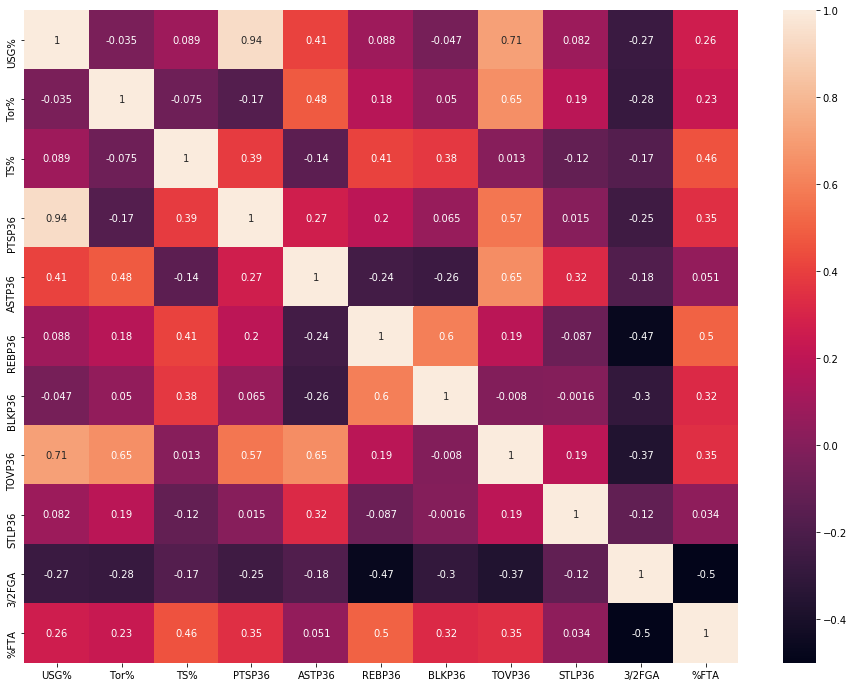

In [5]:
import seaborn as sn
plt.figure(figsize=(16,12))
sn.heatmap(cluster_df.corr(), annot=True)
plt.show()

We can also take a look at the distributions of each stat.

In [6]:
df[cols_to_keep].describe()

,USG%,Tor%,TS%,PTSP36,ASTP36,REBP36,BLKP36,TOVP36,STLP36,3/2FGA,%FTA
count,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000,439.000000
mean,18.803815,12.172347,0.548442,15.354011,3.390419,6.733659,0.763206,1.928709,1.112005,0.768256,0.193681
std,5.172637,3.512914,0.056480,4.700619,1.999456,3.119749,0.701028,0.757269,0.422166,0.684187,0.072765
min,7.771832,3.700000,0.309569,3.380171,0.564706,1.963636,0.000000,0.440288,0.000000,0.000000,0.000000
25%,15.120061,9.700000,0.518000,12.000000,1.862069,4.354168,0.320667,1.355311,0.801617,0.337152,0.140336
50%,17.838496,11.700000,0.552029,14.775244,2.737643,5.890909,0.552879,1.806642,1.062731,0.613833,0.186986
75%,22.100000,14.200000,0.583000,18.070043,4.581818,8.643680,0.978624,2.335425,1.344522,1.073592,0.240191
max,40.500000,26.800000,0.720000,35.315217,10.700000,17.613734,5.337931,4.852174,2.537705,4.886364,0.467742


And, finally, let us plot histograms of the columns.

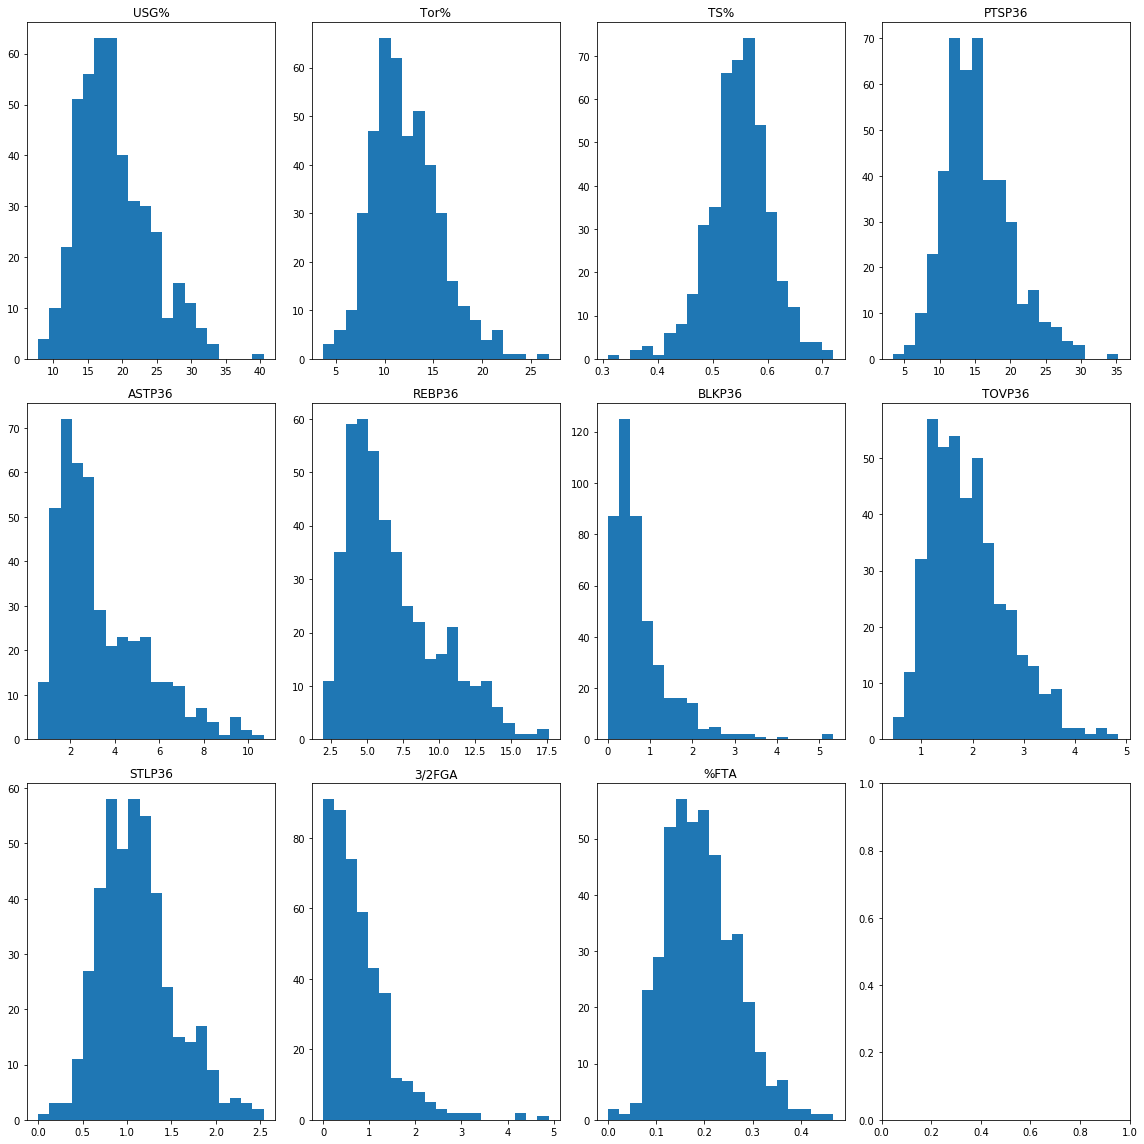

In [7]:
plt.subplots(3, 4, figsize=(16, 16))
for i in range(len(cols_to_keep)):
    plt.subplot(3, 4, i+1)
    plt.hist(cluster_df[cols_to_keep[i]], bins=20)
    plt.title(cols_to_keep[i])
    plt.tight_layout()
plt.show()

### Standardization

From these distributions, it seems the selected stats are approximately normally distributed. In order to avoid scaling issues, let us standardize the columns with z-scores.

In [8]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
cluster_df = pd.DataFrame(scaler.fit_transform(cluster_df), columns=cols_to_keep)
cluster_df.head()

,USG%,Tor%,TS%,PTSP36,ASTP36,REBP36,BLKP36,TOVP36,STLP36,3/2FGA,%FTA
0,-1.278139,-1.217571,-0.734581,-1.131333,-1.128381,-1.248817,-0.575820,-1.422620,-0.165764,5.070300,-1.612638
1,-1.026530,2.145297,-1.319522,-1.322856,1.020516,-0.510495,-0.477892,0.547521,-0.062347,1.883651,-1.624200
2,-0.465248,0.178874,0.754357,-0.079224,-0.834111,1.125046,0.387765,-0.084662,1.171450,-1.120529,0.984179
3,-0.581375,1.404326,1.321572,-0.341395,0.004368,1.458610,0.653207,0.473272,0.587290,-1.077555,1.702403
4,-1.723294,0.435364,-2.205794,-1.992223,-1.167445,-1.028257,-0.031460,-1.056705,-2.218564,1.464684,-1.288909


### Clustering

Let us try models with the number of clusters ranging from 5 to 15.

In [9]:
from sklearn.cluster import KMeans
inertias = []
num_data = cluster_df._get_numeric_data().dropna(axis = 1)
for i in range(5, 15):
    test_model = KMeans(n_clusters = i, random_state = 1) #test using just 5 clusters
    test_model.fit(num_data)
    inertias.append(test_model.inertia_)
print(inertias)

[2602.9895370184718, 2460.9798250186077, 2329.918199993632, 2221.884108924696, 2131.1964458658467, 2054.230500265702, 1988.8877697426751, 1926.8990808606763, 1868.9505624695475, 1825.9513081827922]


We create a plot of the "intertias" per number of clusters and use the elbow method to determine the best number of clusters.

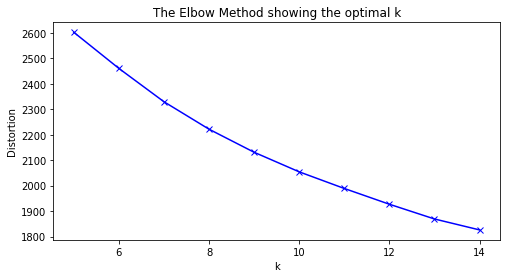

In [10]:
plt.figure(figsize=(8,4))
plt.plot(range(5,15), inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

We select 8 as the number of clusters to continue analyzing.

### Analysis

We can now look at the relative size of each cluster.

In [11]:
num_clusters = 8
test_model = KMeans(n_clusters = num_clusters, random_state = 1)
test_model.fit(num_data)
df['Cluster'] = test_model.labels_
df['Cluster'].value_counts()

2    96
5    81
1    63
0    57
4    46
3    44
6    34
7    18
Name: Cluster, dtype: int64

We can also look at the distribution by position within each cluster.

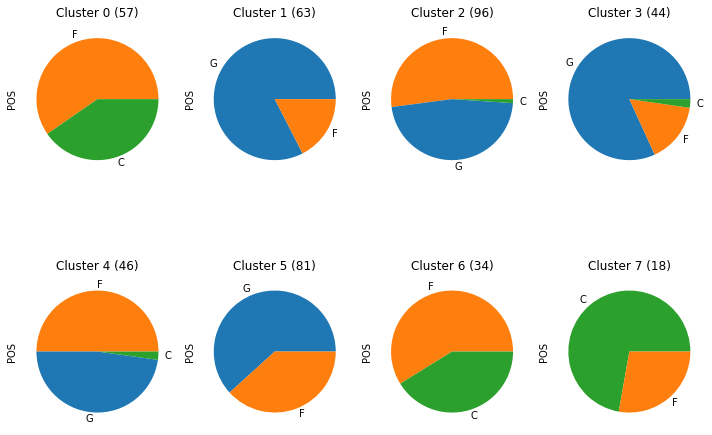

In [12]:
colours = {'G': 'C0', 'F': 'C1', 'C': 'C2'}
plt.subplots(2, 4, figsize=(10, 8))
for i in range(num_clusters):
    plt.subplot(2, 4, i+1)
    counts = df[df['Cluster'] == i]['POS'].value_counts()
    labels = list(counts.index)
    counts.plot.pie(labels=labels, colors=[colours[key] for key in labels])
    plt.title("Cluster " + str(i) + " (" + str(counts.sum()) + ")")
plt.tight_layout()
plt.show()

We notice that as expected, there are significant differences between the position distribution for different clusters. In some cases, we seem to have outliers, such as Centers in clusters 2, 3, and 4. From previous observations, these outliers often made quite a bit of sense. For example, Nikola Jokic was often grouped in a guard-heavy clusters due to his playmaking abilities.

With these patterns in mind, we print out the list of players in each cluster.

In [13]:
for i in range(10):
    print("Cluster "+ str(i))
    print(df[df['Cluster'] == i]['FULL NAME'].values[:])
    print()

Cluster 0
['Steven Adams' 'Bam Adebayo' 'Kyle Anderson' 'Aron Baynes' 'Jordan Bell'
 'Bismack Biyombo' 'Jonah Bolden' 'Wendell Carter Jr.' 'Omri Casspi'
 'Willie Cauley-Stein' 'Zach Collins' 'Ed Davis' 'Dewayne Dedmon'
 'Cheick Diallo' 'Gorgui Dieng' 'Cristiano Felicio' 'Taj Gibson'
 'Marcin Gortat' 'Isaiah Hartenstein' 'John Henson' 'Amir Johnson'
 'Michael Kidd-Gilchrist' 'Kosta Koufos' 'Meyers Leonard' 'Jon Leuer'
 'Kevon Looney' 'Robin Lopez' 'Ian Mahinmi' 'Salah Mejri' 'Paul Millsap'
 'Larry Nance Jr.' 'Joakim Noah' 'Kelly Olynyk' "Kyle O'Quinn"
 'Zaza Pachulia' 'Mason Plumlee' 'Miles Plumlee' 'Quincy Pondexter'
 'Dwight Powell' 'Alex Poythress' 'Ivan Rabb' 'Daniel Theis'
 'Tristan Thompson' 'Noah Vonleh' 'Moritz Wagner' 'Johnathan Williams'
 'Guerschon Yabusele' 'Cody Zeller' 'Ante Zizic' 'Jason Smith'
 'Marc Gasol' 'Pau Gasol' 'Tyson Chandler' 'Skal Labissiere'
 'DeAndre Jordan' 'JaMychal Green' 'Marquese Chriss']

Cluster 1
['Jaylen Adams' 'Kadeem Allen' 'Lonzo Ball' 'Jerryd Ba

Finally, we can look at the distribution of specific statistics within each cluster and contrast.

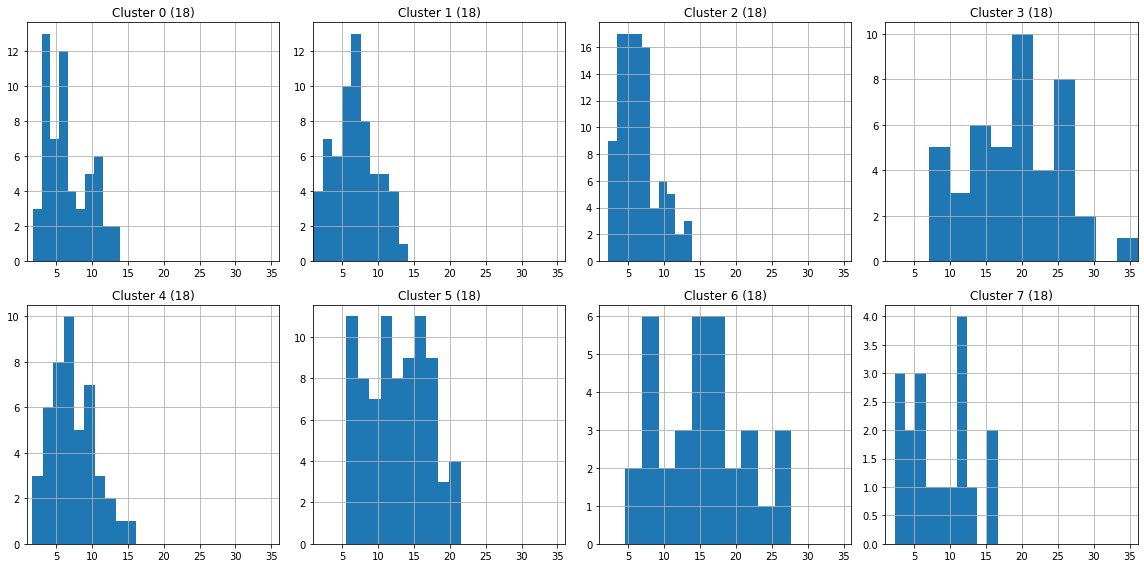

In [14]:
stat = 'PPG'
plt.subplots(2, 4, figsize=(16, 8))
for i in range(num_clusters):
    plt.subplot(2, 4, i+1)
    stats = df[df['Cluster'] == i][stat]
    stats.hist()
    plt.title("Cluster " + str(i) + " (" + str(counts.sum()) + ")")
    plt.xlim(df[stat].min(), df[stat].max())
plt.tight_layout()
plt.show()

From the table below, we see that even though we tried to avoid using volume stats in the clustering process, the resulting clusters were still significantly different in terms of the players' skill. For instance, the average minutes per game across different clusters range from 17 to 30 minutes.

In [15]:
df.groupby('Cluster')[['MPG', 'PPG', 'APG', 'RPG', 'eFG%', '3P%', '3/2FGA']].mean()

,MPG,PPG,APG,RPG,eFG%,3P%,3/2FGA
Cluster,,,,,,,
0,17.294735,6.632541,1.299929,4.984002,0.549647,4.149077,0.275515
1,19.774790,6.873889,3.189169,2.720306,0.464809,5.922915,0.708815
2,19.358849,6.418576,1.300299,3.129639,0.504983,7.504794,0.903070
3,29.988625,19.267346,5.582541,4.807136,0.505872,1.713694,0.548393
4,19.688539,7.371332,1.001476,2.549499,0.528261,7.627301,2.121010
5,25.469018,12.660741,2.301349,3.761368,0.510707,7.880910,0.736672
6,24.609059,15.212506,2.022195,8.129540,0.555832,6.569878,0.195003
7,19.166667,8.544444,0.961111,6.250000,0.622000,0.105778,0.122970
